In [1]:
import os
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
log_dir = "../tensorboard_results"
metrics = []
for root, dirs, files in os.walk(log_dir):
    for file in files:
        if ".csv" in file:
            print(f"Processing: {root}/{file}")
            metrics_df = pd.read_csv(os.path.join(root, file))
            experiment_name = os.path.relpath(file, log_dir).split("/")[-1].replace(".csv", "")
            metrics_df['experiment'] = experiment_name
            metrics.append(metrics_df)
psnr = pd.concat(metrics)
psnr.head()

training_times = {
    "global_2000": 50.31
}

Processing: ../tensorboard_results/sfm_init.csv
Processing: ../tensorboard_results/sfm_nerf2k_init.csv


In [9]:
def plot_psnr(psnr, experiments, by="step", baseline_experiment="SfM"):
    """
    Plot the PSNR values for each experiment and a barplot for final PSNR values,
    with a scaled y-axis in the barplot. Experiment display names are provided via a dictionary.

    Args:
        psnr (pd.DataFrame): DataFrame containing PSNR values with columns ['Step', 'Value', 'experiment'].
        experiments (dict): Dictionary mapping experiment keys to display names.
    """
    # Filter PSNR data for selected experiments
    filtered_psnr = psnr[psnr['experiment'].isin(experiments.keys())]

    # Map experiment names to display names using .assign()
    filtered_psnr = filtered_psnr.assign(
        experiment_display=filtered_psnr['experiment'].map(experiments)
    )

    # Ensure the bar plot follows the order in the experiments dictionary
    filtered_psnr['experiment_display'] = pd.Categorical(
        filtered_psnr['experiment_display'],
        categories=list(experiments.values()),
        ordered=True
    )

    # Rename Wall time to Time
    filtered_psnr = filtered_psnr.rename(columns={"Wall time": "Time"})

    # Line plot for PSNR over by
    x = "Step" if by == "step" else "Time"
    plt.figure(figsize=(12, 6))
    if baseline_experiment is not None and baseline_experiment.lower() in [exp.lower() for exp in experiments.values()]:
        best_baseline_psnr = filtered_psnr[filtered_psnr['experiment'].str.lower() == baseline_experiment.lower()]['Value'].max()
    for experiment, group in filtered_psnr.groupby('experiment_display', observed=True):
        # Convert Time to Time in seconds since the start of the experiment
        if by == "time":
            startup_time = training_times["global_2000"] if "Nerf" in experiment else 0.0
            print(startup_time)
            group[x] = (group[x] - group[x].min() + startup_time)
        experiment_plot = plt.plot(group[x], group['Value'], label=experiment)
        if baseline_experiment is not None and experiment.lower() == baseline_experiment.lower():
            plt.axhline(y=best_baseline_psnr, color=experiment_plot[0].get_color(), linestyle='--', label=f"Best {baseline_experiment} PSNR")
        # Add vertical lines where each experiment reaches the baseline PSNR for the first time
        if baseline_experiment is not None:
            baseline_psnr = group[group['Value'] >= best_baseline_psnr]
            if not baseline_psnr.empty:
                first_x = baseline_psnr[x].iloc[0]
                plt.axvline(x=first_x, color=experiment_plot[0].get_color(), linestyle='--', label=f"{experiment} reaches {baseline_experiment} PSNR")
                # plt.text(first_x, best_baseline_psnr, f"{first_x:.2f}", color=experiment_plot[0].get_color(), ha='right', va='bottom')

    plt.xlabel("Step" if by == "step" else "Time")
    plt.ylabel("PSNR")
    plt.title(f"PSNR vs. {'Step' if by == 'step' else 'Time in seconds'}")
    plt.legend(title="Experiments")
    plt.grid()
    plt.show()

    # Bar plot for final PSNR values
    final_psnr = (
        filtered_psnr.groupby('experiment_display', observed=True)['Value']
        .last()
        .reset_index()
    )

    # Determine y-axis range based on min and max PSNR
    y_min = final_psnr['Value'].min() * 0.95  # Slightly below the minimum
    y_max = final_psnr['Value'].max() * 1.05  # Slightly above the maximum

    plt.figure(figsize=(12, 6))
    bars = plt.bar(final_psnr['experiment_display'], final_psnr['Value'], color='skyblue')
    plt.ylim(y_min, y_max)  # Scale the y-axis based on min and max
    plt.xlabel("Experiment")
    plt.ylabel("Final PSNR")
    plt.title("Final PSNR for Each Experiment")
    plt.xticks(rotation=45)
    plt.grid(axis='y')

    # Add value annotations to bars
    for bar, value in zip(bars, final_psnr['Value']):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
                 f"{value:.2f}", ha='center', va='top', fontsize=10)

    plt.tight_layout()
    plt.show()

0.0
50.31


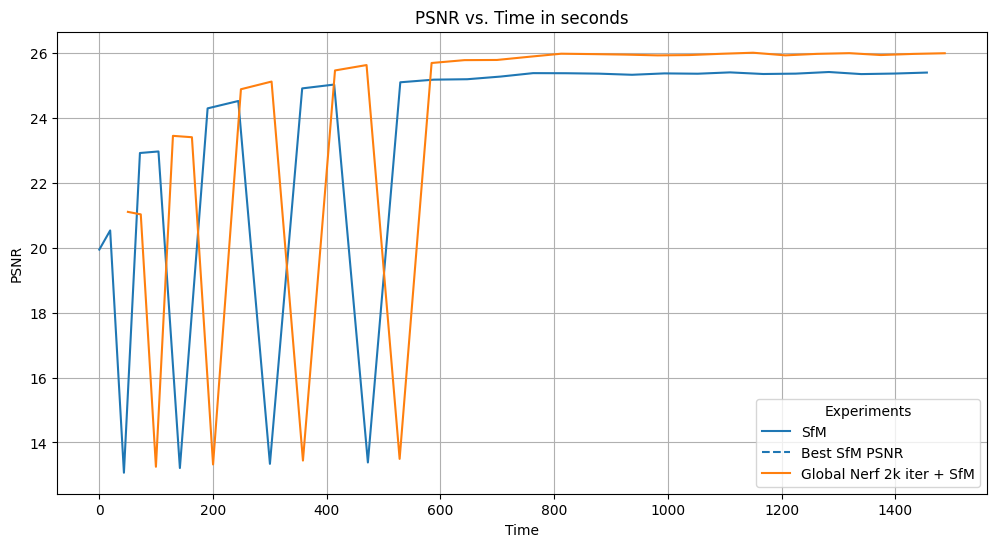

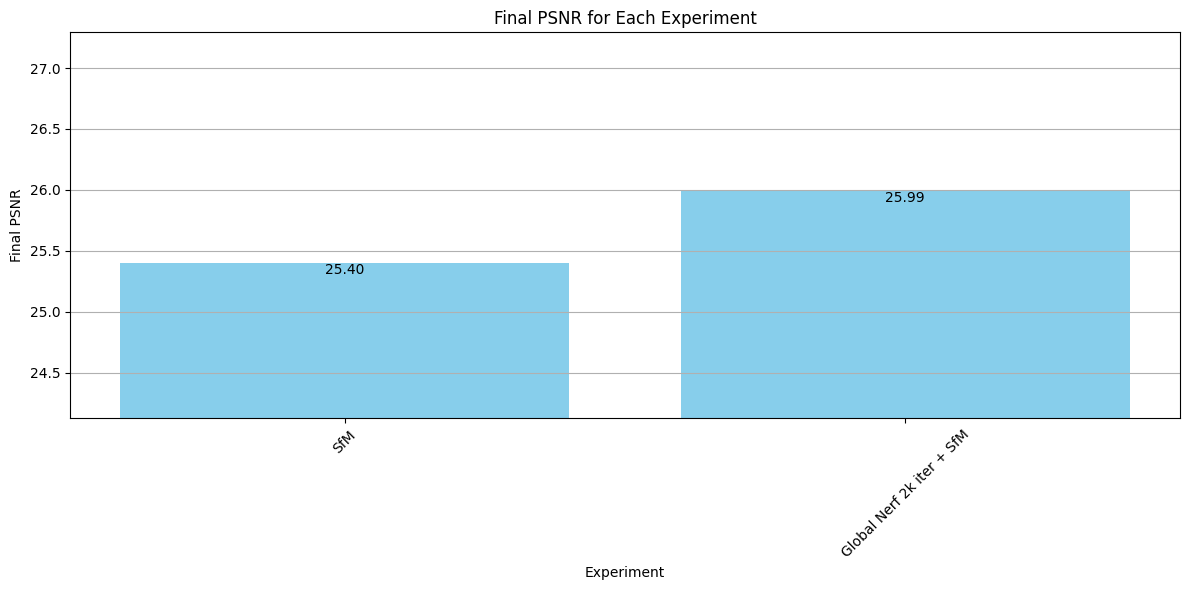

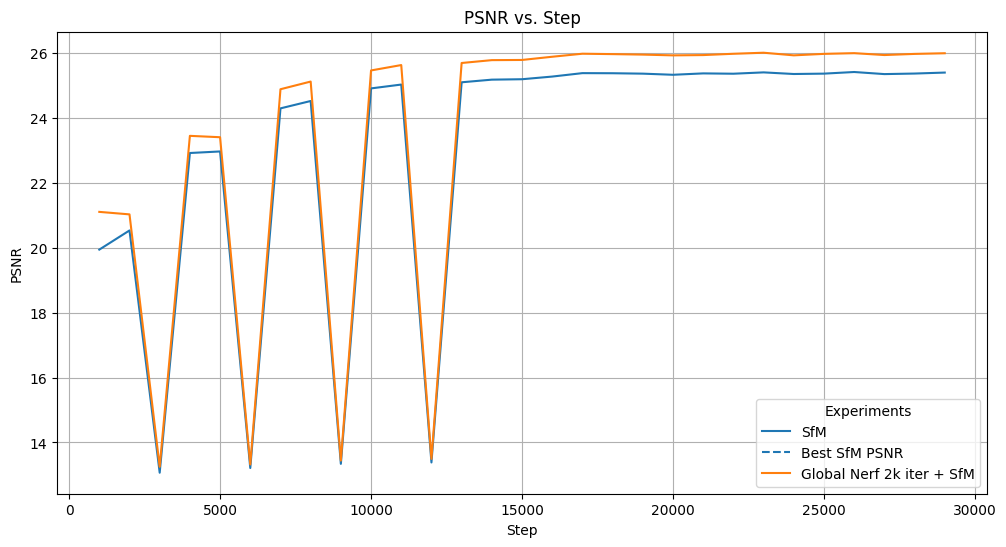

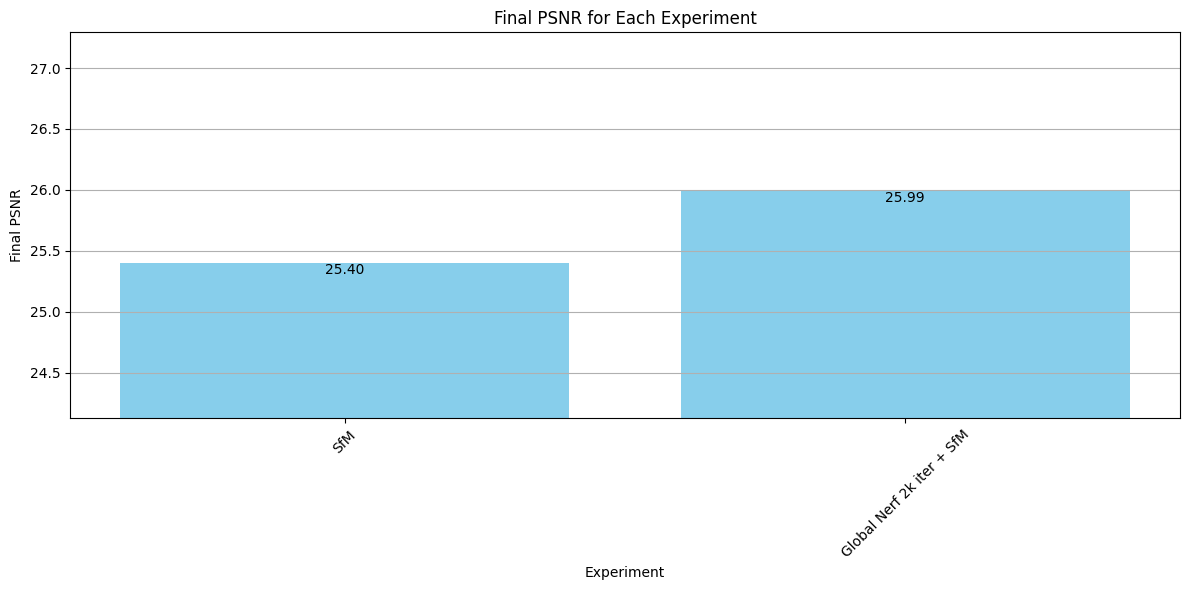

In [10]:
#with plt.rc_context(fname="style.rc"):
    #plot_psnr(psnr, {"sfm": "SfM", "global_1000": "Global NeRF (1000its)", "local_1000": "Local NeRFs (1000its) + SfM", "global_sfm_1000": "Global NeRF (1000its) + SfM"}, by="time")
    #plot_psnr(psnr, {"sfm": "SfM", "global_5000": "Global NeRF (5000its)", "local_5000": "Local NeRFs (5000its) + SfM", "global_sfm_5000": "Global NeRF (5000its) + SfM"})
#plot_psnr(psnr, {"sfm": "SfM", "local_500": "Local NeRFs (500its) + SfM", "local_1000": "Local NeRFs (1000its) + SfM", "local_3000": "Local NeRFs (3000its) + SfM", "local_5000": "Local NeRFs (5000its) + SfM", })
#plot_psnr(psnr, {"sfm": "SfM", "global_sfm_1000": "Global NeRF (1000its) + SfM", "global_sfm_5000": "Global NeRF (5000its) + SfM", "global_sfm_20000": "Global NeRF (20000its) + SfM"})
plot_psnr(psnr, {"sfm_init": "SfM", "sfm_nerf2k_init": "Global Nerf 2k iter + SfM"}, by="time")
plot_psnr(psnr, {"sfm_init": "SfM", "sfm_nerf2k_init": "Global Nerf 2k iter + SfM"})

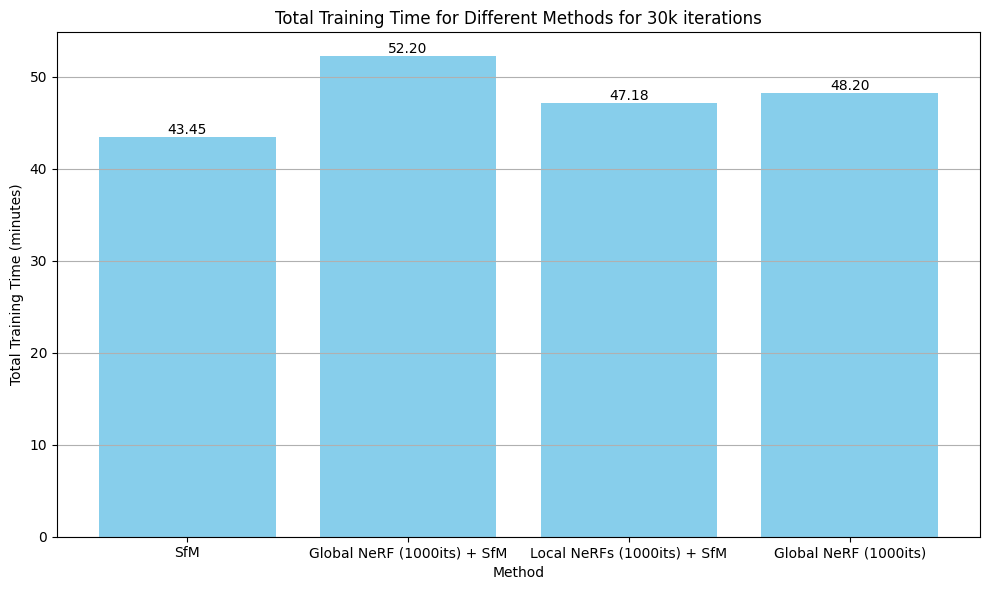

In [54]:
training_times_per_iteration = {
    500: 12.35,
    1000: 24.61,
    3000: 71.69,
    5000: 116.86,
}

gs_times = {
    "SfM": 2607,
    "Global NeRF (1000its) + SfM": 3132,
    "Local NeRFs (1000its) + SfM": 2831,
    "Global NeRF (1000its)": 2892,
}

# to minutes
for key in gs_times:
    gs_times[key] = gs_times[key] / 60.

def plot_training_times(training_times_per_iteration):
    """
    Plot the training times per iteration for different numbers of iterations.

    Args:
        training_times_per_iteration (dict): Dictionary mapping number of iterations to training times.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(list(training_times_per_iteration.keys()), list(training_times_per_iteration.values()), marker='o')
    plt.xlabel("Number of Iterations")
    plt.ylabel("Training Time (seconds)")
    plt.title("Training Time per Iteration")
    plt.grid()
    plt.show()

def plot_gs_times(gs_times):
    """
    Plot the total training times for different methods.

    Args:
        gs_times (dict): Dictionary mapping methods to total training times.
    """
    plt.figure(figsize=(10, 6))
    bars = plt.bar(gs_times.keys(), gs_times.values(), color='skyblue')
    plt.xlabel("Method")
    plt.ylabel("Total Training Time (minutes)")
    plt.title("Total Training Time for Different Methods for 30k iterations")
    plt.grid(axis='y')

    # Add value annotations to bars
    for bar, value in zip(bars, gs_times.values()):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
                 f"{value:.2f}", ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()

plot_gs_times(gs_times)